In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('results/master_file.csv', sep=';')

In [6]:
df.shape

(176570, 12)

In [7]:
df.drop('Request ID', axis=1, inplace=True)
df.drop('Test case name', axis=1, inplace=True)
df.drop('Test suite name', axis=1, inplace=True)

In [14]:
df.columns

Index(['Endpoint', 'Method', 'Status Code', 'Start time',
       'Duration till headers received[ms]', 'Duration till body received[ms]',
       'Request Body Length', 'Response Body Length', 'Test Result'],
      dtype='object')

In [15]:
df.describe(include='all')

,Endpoint,Method,Status Code,Start time,Duration till headers received[ms],Duration till body received[ms],Request Body Length,Response Body Length,Test Result
count,176570,176570,176570.000000,176570,176570.000000,176570.000000,176570.000000,176570.000000,176570
unique,41,4,NaN,176570,NaN,NaN,NaN,NaN,2
top,/g/user,POST,NaN,2023-04-03 15:14:23.030,NaN,NaN,NaN,NaN,PASS
freq,55996,84716,NaN,1,NaN,NaN,NaN,NaN,173285
mean,NaN,NaN,229.567203,NaN,644.561149,737.753746,113.169259,615.292734,NaN
std,NaN,NaN,71.643950,NaN,2055.052325,3232.821377,216.993416,1072.367875,NaN
min,NaN,NaN,200.000000,NaN,0.000000,2.000000,0.000000,0.000000,NaN
25%,NaN,NaN,200.000000,NaN,68.000000,73.000000,0.000000,24.000000,NaN
50%,NaN,NaN,200.000000,NaN,121.000000,126.000000,36.000000,179.000000,NaN
75%,NaN,NaN,200.000000,NaN,460.000000,472.000000,83.000000,997.000000,NaN


In [16]:
# Max response time
df.iloc[df['Duration till body received[ms]'].idxmax()]

Endpoint                              /g/metric/camerabandwidth
Method                                                      GET
Status Code                                                 200
Start time                              2023-04-11 22:05:12.339
Duration till headers received[ms]                       167193
Duration till body received[ms]                          167197
Request Body Length                                           0
Response Body Length                                       8899
Test Result                                                PASS
Name: 13374, dtype: object

# The average response time by endpoint

#### Remove the FAILS from dataframe 

In [17]:
df_no_fail = df[df['Test Result'] != 'FAIL'].copy()

In [18]:
grouped = df_no_fail.groupby('Endpoint')['Duration till body received[ms]'].mean()

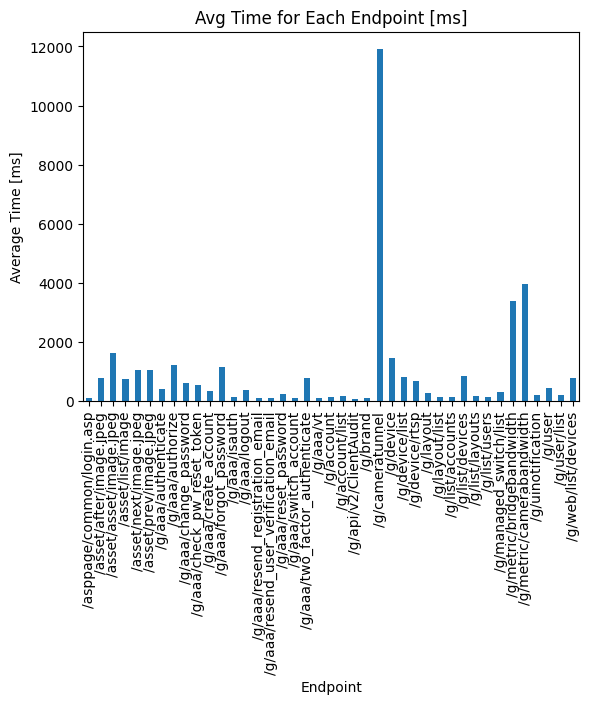

In [19]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Average Time [ms]')
plt.title('Avg Time for Each Endpoint [ms]')
plt.show()

## Median response time at each hour - all endpoints

In [8]:
from pytz import timezone

# Convert 'Start time' column to datetime data type
df['Start time'] = pd.to_datetime(df['Start time'])

# Convert the timezone of the datetime object from UTC to CST
df['Start Time CST'] = df['Start time'].dt.tz_localize('UTC')
df['Start Time CST'] = df['Start Time CST'].dt.tz_convert('US/Central')

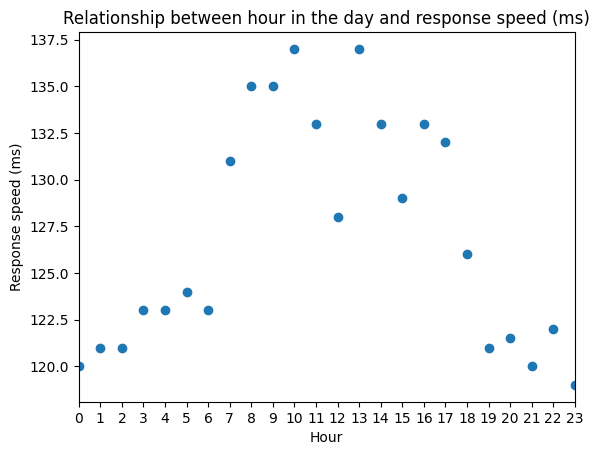

In [9]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour

#Calculate the mean duration for each hour
hourly_mean_duration = df.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()


## Median response time at each day - all endpoints

/var/folders/sb/rj34nx016wd_j9g3qx1420xm0000gn/T/ipykernel_2025/309887515.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = pd.concat([all_dates.set_index('Date'), daily_mean_duration], axis=1, join='outer')


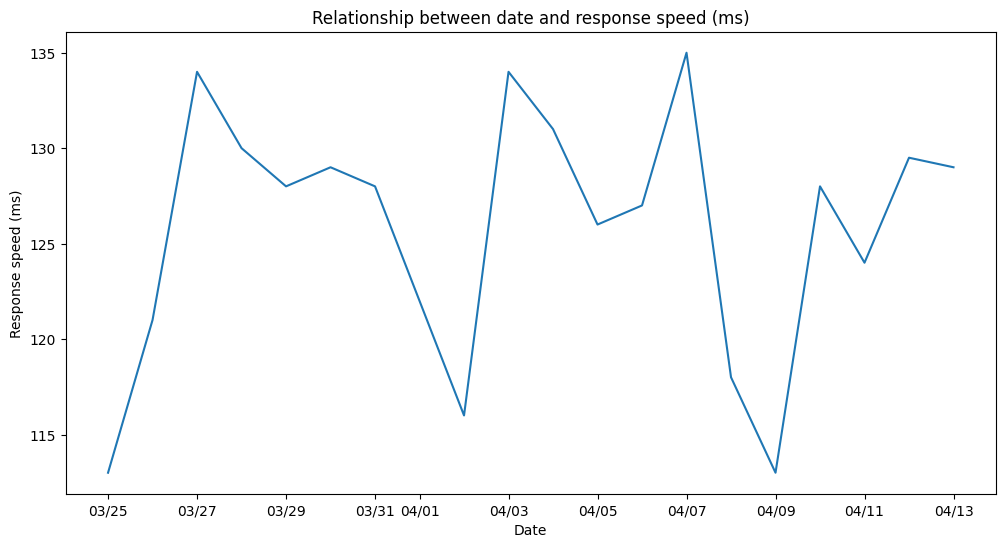

In [19]:
from matplotlib import dates as mpl_dates

# Create a new column with the date value
df['Date'] = df['Start Time CST'].dt.date

# Calculate the mean duration for each day
daily_mean_duration = df.groupby('Date')['Duration till body received[ms]'].median()

# Create a new dataframe with all dates included
all_dates = pd.DataFrame({'Date': pd.date_range(start=df['Start Time CST'].min().date(), end=df['Start Time CST'].max().date())})

# Concatenate the daily mean duration data with the all-dates dataframe
result = pd.concat([all_dates.set_index('Date'), daily_mean_duration], axis=1, join='outer')

# Forward fill the missing values
result['Duration till body received[ms]'] = result['Duration till body received[ms]'].fillna(method='ffill')

# Build line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(result.index, result['Duration till body received[ms]'])
ax.set_xlabel('Date')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between date and response speed (ms)')

# Format the x-axis tick labels to display only the month and day
date_format = mpl_dates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(date_format)

plt.show()

## Speed throughout the day for endpoint - g/aaa/authenticate

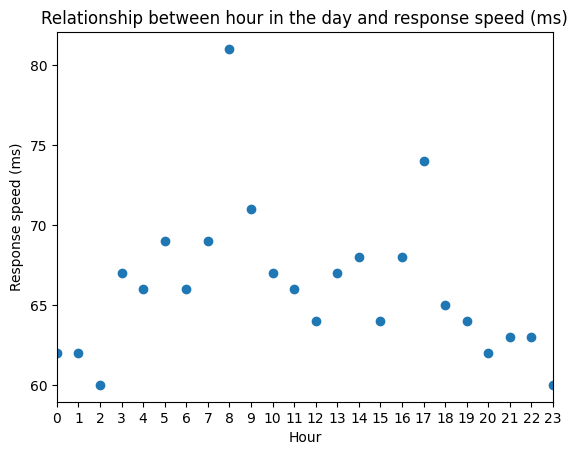

In [22]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour
df_auth = df[df['Endpoint'] == '/g/aaa/authenticate']

#Calculate the mean duration for each hour
hourly_mean_duration = df_auth.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()

# Median reponse time for PASS and FAIL

In [23]:
avg_time_by_result = df.groupby('Test Result')['Duration till body received[ms]'].median()
print(avg_time_by_result)

Test Result
FAIL    162.0
PASS    126.0
Name: Duration till body received[ms], dtype: float64


In [24]:
# Group the DataFrame by endpoint and Method, and calculate the median response time for each group
grouped = df.groupby(['Endpoint', 'Method', 'Test Result']).agg({'Duration till body received[ms]': 'median'}).reset_index()

# Filter the grouped DataFrame to include only PASS and FAIL results
grouped_pass = grouped[grouped['Test Result'] == 'PASS']
grouped_fail = grouped[grouped['Test Result'] == 'FAIL']

# Merge the two DataFrames
result = pd.merge(grouped_pass, grouped_fail, on=['Endpoint', 'Method'], suffixes=('_pass', '_fail'))

# Rename the column headers to be more concise
result = result.rename(columns={'Test Result_pass': 'Result', 'Test Result_fail': 'Result','Duration till body received[ms]_pass': 'Pass_median', 'Duration till body received[ms]_fail': 'Fail_median'})
print(result)

                     Endpoint  Method Result  Pass_median Result  Fail_median
0           /asset/list/image     GET   PASS         55.0   FAIL      10026.0
1      /asset/prev/image.jpeg     GET   PASS        195.5   FAIL        124.0
2         /g/aaa/authenticate    POST   PASS         65.0   FAIL         63.0
3            /g/aaa/authorize    POST   PASS        681.0   FAIL        146.0
4      /g/aaa/change_password    POST   PASS         98.0   FAIL         93.0
5      /g/aaa/forgot_password    POST   PASS        375.0   FAIL        763.5
6               /g/aaa/logout    POST   PASS         82.0   FAIL         75.0
7             /g/cameratunnel     PUT   PASS       4030.0   FAIL      63366.0
8                   /g/device  DELETE   PASS        673.0   FAIL        796.0
9                   /g/device     GET   PASS        185.0   FAIL        245.0
10                  /g/device     PUT   PASS       1170.0   FAIL      33245.0
11                  /g/layout  DELETE   PASS        120.0   FAIL

# The response length by endpoint

In [25]:
grouped = df_no_fail.groupby('Endpoint')['Response Body Length'].mean()

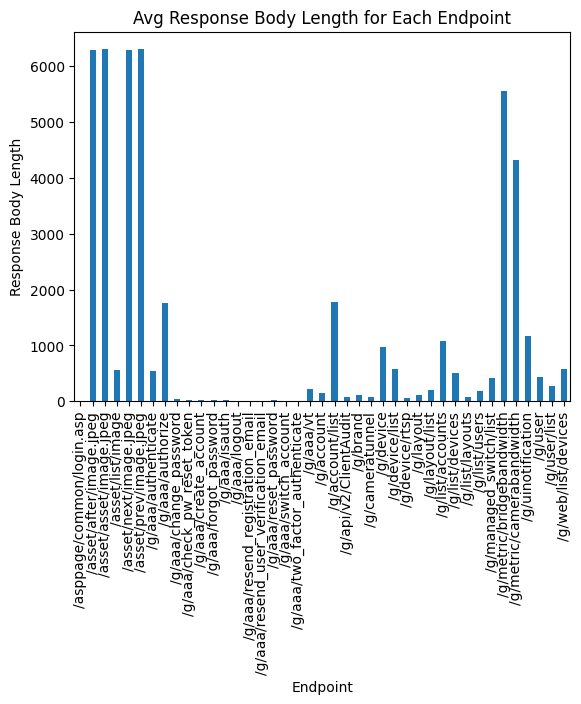

In [26]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Response Body Length')
plt.title('Avg Response Body Length for Each Endpoint')
plt.show()

# Does length of response payload and response speed correlate?

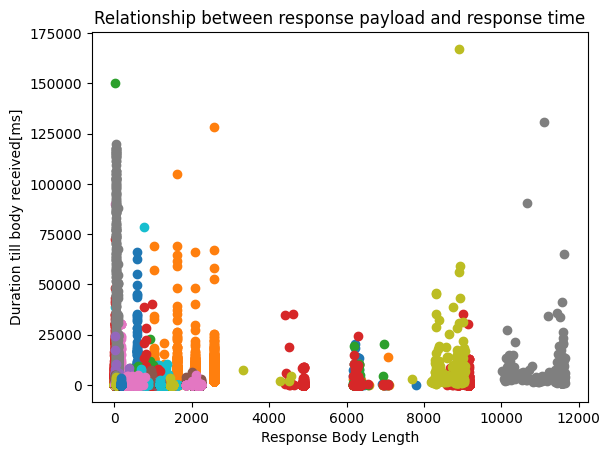

In [27]:
grouped = df_no_fail.groupby(['Endpoint', 'Response Body Length'])['Duration till body received[ms]'].median()

# create a scatter plot to represent the relationship between response payload and response time
fig, ax = plt.subplots()
for endpoint in df_no_fail['Endpoint'].unique():
    endpoint_df = df_no_fail[df_no_fail['Endpoint'] == endpoint]
    ax.scatter(endpoint_df['Response Body Length'], endpoint_df['Duration till body received[ms]'], label=endpoint)
ax.set_xlabel('Response Body Length')
ax.set_ylabel('Duration till body received[ms]')
ax.set_title('Relationship between response payload and response time')
#ax.legend()
plt.show()

In [28]:
length_time_df = df_no_fail[['Response Body Length', 'Duration till body received[ms]']]

corr = length_time_df.corr().iloc[0,1]

print('Correlation Coefficient: ', corr)

Correlation Coefficient:  0.07039954417470053
